In [8]:
import argparse
import os
import muon as mu
import pandas as pd
import pyranges as pr
import sys
import numpy as np

import matplotlib.pyplot as plt

from typing import Literal
from sklearn.metrics import (
    roc_auc_score, 
    average_precision_score, 
    roc_curve, 
    precision_recall_curve
)


from pathlib import Path

# Add the parent directory (assuming utils is in ../utils)
# Add the parent directory of the current working directory
sys.path.append(str(Path().resolve().parent))

from utils.benchmarking_metrics import *

GRN_TOOLS = Literal["scenicplus", "celloracle"]
SCORE_COL = "score_rank"
TF2GENE_W_COL = "TF2Gene_weight"

def modality_names(grn_tool:GRN_TOOLS, cell_type_col, sample):
    if grn_tool == "scenicplus":
        if "metacell_0" in sample:
            return "scRNA_counts", "scATAC_counts", f"scRNA_counts:{cell_type_col}"
        else:
            return "scRNA_counts", "scATAC_counts", "scRNA_counts:Metacell_Key"

def get_adata(mudata, grn_tool:GRN_TOOLS):
    if grn_tool == "scenicplus":
        return mudata["scRNA_counts"]
    else:
        raise ValueError(f"Unsupported GRN inference tool: {grn_tool}")


def get_mudata(path:str, grn_tool:GRN_TOOLS):
    if grn_tool == "scenicplus":
        scplus_mdata = mu.read_h5mu(path)
        return scplus_mdata
    else:
        raise ValueError(f"Unsupported GRN inference tool: {grn_tool}")

# GRNs need to have the following columns: "TF", "Gene", "Region"
def preprocess_scenicplus(scplus_mdata):
    # Extract metadata
    direct_df = pd.DataFrame(scplus_mdata.uns['direct_e_regulon_metadata'])
    extended_df = pd.DataFrame(scplus_mdata.uns['extended_e_regulon_metadata'])

    # Combine into one DataFrame
    grn = pd.concat([direct_df, extended_df], ignore_index=True)

    # Filter the relevant columns
    grn_filtered = grn[['Region', 'Gene', 'TF', 'importance_TF2G', 'importance_R2G','regulation', 'rho_TF2G', 'triplet_rank']].copy()

    # Split the 'Region' column into Chromosome, Start, End
    region_split = grn_filtered['Region'].str.extract(r'(chr[\w]+):(\d+)-(\d+)')
    region_split.columns = ['Chromosome', 'Start', 'End']

    # Convert Start and End to integers
    region_split['Start'] = region_split['Start'].astype(int)
    region_split['End'] = region_split['End'].astype(int)

    grn = pd.concat([region_split, grn_filtered], axis=1)

    max_rank = grn["triplet_rank"].max()
    min_rank = grn["triplet_rank"].min()

    grn[SCORE_COL] = (max_rank - grn["triplet_rank"]) / (max_rank - min_rank)

    raw = grn["importance_TF2G"] * grn["rho_TF2G"]
    grn[TF2GENE_W_COL] = np.tanh(3 * raw) 

    return grn

def get_grn_matrix(mudata, grn_tool:GRN_TOOLS):
    if grn_tool == "scenicplus":
        return preprocess_scenicplus(mudata)

def get_benchmark_matrix(tfb_path, prt_path, frc_path, gst_path, tfm_path):
    tfb_matrix = pd.read_csv(tfb_path, sep="\t", header=None)
    tfb_matrix.columns = ["Chromosome", "Start", "End", "TF"]

    prt_matrix = pd.read_csv(prt_path, sep=',')

    frc_matrix = pd.read_csv(frc_path, index_col=0, sep=',')

    gst_matrix = pd.read_csv(gst_path)

    tfm_matrix = df = pd.read_csv(tfm_path, header=None, names=['gene'])

    return tfb_matrix, prt_matrix, frc_matrix, gst_matrix, tfm_matrix





In [2]:
grn_file = "/data/tmpA/andrem/scenicplus/results/AML16_REM_metacell_2/scplusmdata.h5mu"

tfb_goldenf = "/data/benchmarks/andrem/data/pAML/benchmarks/tf-binding-test/dbs/tf_bind_db.bed"
prt_goldenf = "/data/benchmarks/andrem/data/pAML/benchmarks/tf-actvity/knock_tf_benchmark_data.csv"
frc_goldenf = "/data/benchmarks/andrem/data/pAML/benchmarks/tf-actvity/knock_tf_benchmark_data.csv"
gst_goldenf = "/data/benchmarks/andrem/data/pAML/benchmarks/gsets/merged_network.csv"
tfm_goldenf = "/data/benchmarks/andrem/data/pAML/benchmarks/tfm/filtered_tf_markers.txt"
grn_tool = "scenicplus"


In [3]:
mudata = get_mudata(grn_file, grn_tool)
grn_inferred = get_grn_matrix(mudata, grn_tool)
adata = get_adata(mudata, grn_tool)


In [4]:
tfb_golden, prt_golden, frc_golden, gst_matrix, tfm_matrix = get_benchmark_matrix(
    tfb_goldenf, 
    prt_goldenf, 
    frc_goldenf,
    gst_goldenf,
    tfm_goldenf
)


In [92]:
tfb_benchmark = tfb_test(
    grn_inferred=grn_inferred, 
    tf_binding_matrix=tfb_golden, 
    score_column=SCORE_COL
)


In [ ]:
# Benchmark PRT
prt_benchmark = prt_test(
    grn_inferred=grn_inferred, 
    prt_matrix=prt_golden, 
    score_column=SCORE_COL,
    weight_column=TF2GENE_W_COL,
    step = 0.01
)


Threshold: 0.00
Threshold: 0.01
Threshold: 0.02
Threshold: 0.03
Threshold: 0.04
Threshold: 0.05
Threshold: 0.06
Threshold: 0.07
Threshold: 0.08
Threshold: 0.09
Threshold: 0.10
Threshold: 0.11
Threshold: 0.12
Threshold: 0.13
Threshold: 0.14
Threshold: 0.15
Threshold: 0.16
Threshold: 0.17
Threshold: 0.18
Threshold: 0.19
Threshold: 0.20
Threshold: 0.21
Threshold: 0.22
Threshold: 0.23
Threshold: 0.24
Threshold: 0.25
Threshold: 0.26
Threshold: 0.27
Threshold: 0.28
Threshold: 0.29
Threshold: 0.30
Threshold: 0.31
Threshold: 0.32
Threshold: 0.33
Threshold: 0.34
Threshold: 0.35
Threshold: 0.36
Threshold: 0.37
Threshold: 0.38
Threshold: 0.39
Threshold: 0.40
Threshold: 0.41
Threshold: 0.42
Threshold: 0.43
Threshold: 0.44
Threshold: 0.45
Threshold: 0.46
Threshold: 0.47
Threshold: 0.48
Threshold: 0.49
Threshold: 0.50
Threshold: 0.51
Threshold: 0.52
Threshold: 0.53
Threshold: 0.54
Threshold: 0.55
Threshold: 0.56
Threshold: 0.57
Threshold: 0.58
Threshold: 0.59
Threshold: 0.60
Threshold: 0.61
Threshol

<module 'utils.benchmarking_metrics' from '/home/andrem/GRN-project/workflow/utils/benchmarking_metrics.py'>

In [90]:
frc_benchmark = frc_test(
    grn_inferred=grn_inferred, 
    adata=adata,
    frc_matrix=frc_golden,
    score_column=SCORE_COL,
    step = 0.05
)

100%|██████████| 132/132 [01:19<00:00,  1.66it/s]


Threshold: 0.00


  8%|▊         | 11/132 [00:14<02:39,  1.32s/it]


KeyboardInterrupt: 

In [9]:
celltype_col = "Classified_Celltype"
sample = "AML16_REM_metacell_2"

rna_mod_name, atac_mod_name, celltype_col = modality_names(grn_tool, celltype_col, sample)
# Omics TF-Gene´
omics_tf2g = omic_test(
    grn_inferred = grn_inferred,
    mdata = mudata,
    score_column = SCORE_COL,
    source_column = "TF",
    target_column = "Gene",
    mod_source = rna_mod_name,
    mod_target= rna_mod_name,
    celltype_column= celltype_col,
    step = 0.3
)

  0%|          | 1/4745 [00:26<35:03:03, 26.60s/it]


KeyboardInterrupt: 

In [10]:
# Omics CRE-Gene
omics_r2g = omic_test(
    grn_inferred = grn_inferred,
    mdata = mudata,
    score_column = SCORE_COL,
    source_column = "Region",
    target_column = "Gene",
    mod_source = atac_mod_name,
    mod_target= rna_mod_name,
    celltype_column= celltype_col,
    step = 0.2
)

  1%|          | 45/4745 [00:03<06:39, 11.77it/s]


KeyboardInterrupt: 

In [11]:
# Omics CRE-TF
omics_r2tf = omic_test(
    grn_inferred = grn_inferred,
    mdata = mudata,
    score_column = SCORE_COL,
    source_column = "Region",
    target_column = "TF",
    mod_source = atac_mod_name,
    mod_target= rna_mod_name,
    celltype_column= celltype_col,
    step = 0.2
)

  0%|          | 0/40 [00:00<?, ?it/s]

 78%|███████▊  | 31/40 [00:03<00:00,  9.73it/s]


KeyboardInterrupt: 

In [52]:
import importlib
import utils.benchmarking_metrics 
from utils.benchmarking_metrics import *

importlib.reload(utils.benchmarking_metrics)

<module 'utils.benchmarking_metrics' from '/home/andrem/GRN-project/workflow/utils/benchmarking_metrics.py'>

In [53]:
gst_benchmark = gst_test(
    grn_inferred=grn_inferred, 
    ptw=gst_matrix, 
    rna=adata,
    score_column=SCORE_COL,
    step=0.01
)

Threshold: 0.01
Precision: 0.8788, Recall: 0.0420, F-beta: 0.7339
Threshold: 0.02
Precision: 0.8824, Recall: 0.0434, F-beta: 0.7407
Threshold: 0.03
Precision: 0.8824, Recall: 0.0434, F-beta: 0.7407
Threshold: 0.04
Precision: 0.8824, Recall: 0.0434, F-beta: 0.7407
Threshold: 0.05
Precision: 0.8824, Recall: 0.0434, F-beta: 0.7407
Threshold: 0.06
Precision: 0.8824, Recall: 0.0434, F-beta: 0.7407
Threshold: 0.07
Precision: 0.8824, Recall: 0.0434, F-beta: 0.7407
Threshold: 0.08
Precision: 0.8824, Recall: 0.0434, F-beta: 0.7407
Threshold: 0.09
Precision: 0.8824, Recall: 0.0434, F-beta: 0.7407
Threshold: 0.10
Precision: 0.8824, Recall: 0.0434, F-beta: 0.7407
Threshold: 0.11
Precision: 0.8824, Recall: 0.0434, F-beta: 0.7407
Threshold: 0.12
Precision: 0.8824, Recall: 0.0434, F-beta: 0.7407
Threshold: 0.13


KeyboardInterrupt: 

In [30]:
import importlib
import utils.benchmarking_metrics 
from utils.benchmarking_metrics import *

importlib.reload(utils.benchmarking_metrics)

<module 'utils.benchmarking_metrics' from '/home/andrem/GRN-project/workflow/utils/benchmarking_metrics.py'>

In [63]:
tfm_matrix

,gene
0,AEBP1
1,AHR
2,AHRR
3,AKNA
4,ALX1
...,...
846,ZNF143
847,ZNF398
848,ZNF45
849,ZNF692


In [54]:
tfm_benchmark = tfm_test(
    grn_inferred=grn_inferred, 
    db=tfm_matrix, 
    adata=adata,
    score_column=SCORE_COL,
    step=0.01
)


Threshold: 0.01
Precision: 0.7000, Recall: 0.0335, F-beta: 0.5849
Threshold: 0.02
Precision: 0.7000, Recall: 0.0335, F-beta: 0.5849
Threshold: 0.03
Precision: 0.7000, Recall: 0.0335, F-beta: 0.5849
Threshold: 0.04
Precision: 0.7000, Recall: 0.0335, F-beta: 0.5849
Threshold: 0.05
Precision: 0.7000, Recall: 0.0335, F-beta: 0.5849
Threshold: 0.06
Precision: 0.7000, Recall: 0.0335, F-beta: 0.5849
Threshold: 0.07
Precision: 0.7000, Recall: 0.0335, F-beta: 0.5849
Threshold: 0.08
Precision: 0.7000, Recall: 0.0335, F-beta: 0.5849
Threshold: 0.09
Precision: 0.7000, Recall: 0.0335, F-beta: 0.5849
Threshold: 0.10
Precision: 0.7000, Recall: 0.0335, F-beta: 0.5849
Threshold: 0.11
Precision: 0.7000, Recall: 0.0335, F-beta: 0.5849
Threshold: 0.12
Precision: 0.7000, Recall: 0.0335, F-beta: 0.5849
Threshold: 0.13
Precision: 0.7000, Recall: 0.0335, F-beta: 0.5849
Threshold: 0.14
Precision: 0.7000, Recall: 0.0335, F-beta: 0.5849
Threshold: 0.15
Precision: 0.7000, Recall: 0.0335, F-beta: 0.5849
Threshold:

In [67]:
tfm_benchmark

{'tp': 77,
 'fp': 33,
 'fn': 758,
 'precision': 0.7,
 'recall': 0.09221556886227544,
 'fbeta': 0.6571187156738486,
 'auroc': nan,
 'auprc': 0.0770899600044084,
 'best_threshold': 0.99,
 'best_fbeta': 0.7281903388608507,
 'best_precision': 0.819672131147541,
 'best_recall': 0.059880239520958084}

In [85]:
num_unique = grn_inferred["score_rank"].round(2).nunique()

In [86]:
num_unique

101

In [87]:
grn_inferred

,Chromosome,Start,End,Region,Gene,TF,importance_TF2G,importance_R2G,regulation,rho_TF2G,triplet_rank,score_rank,TF2Gene_weight
0,chr17,55672545,55673045,chr17:55672545-55673045,PCTP,ATF4,1.001423,0.020373,1,0.075926,4753,0.859723,0.224226
1,chr17,75969977,75970477,chr17:75969977-75970477,WBP2,ATF4,1.072571,0.032017,1,0.072392,23537,0.305345,0.228812
2,chr2,152611760,152612260,chr2:152611760-152612260,PRPF40A,ATF4,1.165450,0.061384,1,0.085792,8558,0.747425,0.291275
3,chr1,89956984,89957484,chr1:89956984-89957484,ZNF326,ATF4,1.345857,0.016973,1,0.076129,27887,0.176962,0.298047
4,chr1,43867883,43868383,chr1:43867883-43868383,ATP6V0B,ATF4,1.780124,0.021054,1,0.217779,11875,0.649529,0.822022
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51643,chr18,3279128,3279628,chr18:3279128-3279628,MYL12A,TCF4,0.603821,0.076925,-1,-0.094790,1589,0.953103,-0.170041
51644,chr19,49443334,49443834,chr19:49443334-49443834,NOSIP,TCF4,0.407207,0.012764,-1,-0.072442,5020,0.851843,-0.088266
51645,chr17,63954340,63954840,chr17:63954340-63954840,PSMC5,TCF4,1.355978,0.024230,-1,-0.071852,6881,0.796919,-0.284241
51646,chr11,67444053,67444553,chr11:67444053-67444553,CORO1B,TCF4,1.190088,0.014211,-1,-0.071135,11508,0.660361,-0.248649


In [1]:
matches_path = "/data/tmpA/andrem/data-integration/scbridge/out/AML12_REL/matches.csv"
adata_rna_path = "/data/benchmarks/andrem/input_rna/AML12_REL_filtered.h5ad"

In [3]:
import pandas as pd
import scanpy as sc
match_data = pd.read_csv(matches_path, sep=",")

/home/andrem/GRN-project/workflow/.snakemake/conda/709eaa59f238abd9122042b81bdb93cd_/lib/python3.10/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
import scanpy as sc
adata = sc.read_h5ad(adata_rna_path)

/home/andrem/GRN-project/workflow/.snakemake/conda/709eaa59f238abd9122042b81bdb93cd_/lib/python3.10/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [5]:
match_data

,RNA,ATAC,Weight,RNA_embedding,ATAC_embedding
0,AAACCCAAGCAACTTC-1___AML12_REL,CGTAAACTCACTAGGT-1___AML12_REL,0.49,[ 6.7561178e+00 1.9991821e+00 1.4686984e+00 ...,[ 7.01728249e+00 1.97348177e+00 1.59097147e+...
1,AAACCCAGTCTCGACG-1___AML12_REL,CAAGAAAGTCTAAGAA-1___AML12_REL,0.30,[ 8.4478945e-02 -7.0185429e-01 -3.0397162e+00 ...,[ 0.3231845 -0.9699475 -2.5784266 7.022825...
2,AAACCCATCAACTGAC-1___AML12_REL,CTCTCGATCACGATTG-1___AML12_REL,0.00,[ 1.35504723e+00 2.13249159e+00 5.00552773e-...,[ 5.72113574e-01 -2.43634439e+00 -4.95514917e+...
3,AAACGAAAGCTTAGTC-1___AML12_REL,GACTAGTAGTCCGATT-1___AML12_REL,0.50,[ 6.76221371e-01 1.98595679e+00 -1.65637732e+...,[ 1.9089988e+00 5.2119265e+00 2.6001663e+00 ...
4,AAACGAAAGTAATTGG-1___AML12_REL,CTTGTCGCACACTAGT-1___AML12_REL,0.95,[ 6.3245606e+00 1.3716106e+00 2.8706651e+00 ...,[ 6.21555519e+00 1.08253562e+00 3.22481179e+...
...,...,...,...,...,...
4350,TTTGGTTTCATCGCAA-1___AML12_REL,AATGGCTAGCTCCGGT-1___AML12_REL,0.61,[ 6.60280848e+00 1.45593727e+00 1.72672522e+...,[ 7.0605898e+00 1.3968595e+00 1.5214397e+00 ...
4351,TTTGTTGCAATCACGT-1___AML12_REL,AACTGGTGTGCTTGAT-1___AML12_REL,0.00,[ 1.64713359e+00 1.12875152e+00 6.65519595e-...,[-5.0670443e+00 4.6396227e+00 -9.8665160e-01 ...
4352,TTTGTTGCACCCTGAG-1___AML12_REL,ACTGCAAAGAACGTTA-1___AML12_REL,0.86,[ 6.10304117e+00 2.42924285e+00 2.44050360e+...,[ 6.12236643e+00 2.19525194e+00 2.50099492e+...
4353,TTTGTTGCATTAGGCT-1___AML12_REL,CTTCTAAGTTCCAGTA-1___AML12_REL,0.32,[-3.4294796e+00 -3.1848600e+00 3.8791380e+00 ...,[-5.03077841e+00 -1.30104351e+00 3.56661868e+...


In [6]:
adata

AnnData object with n_obs × n_vars = 4355 × 33538
    obs: 'patient', 'dx', 'sample', 'batch', 'GEO_ID', 'Lambo_et_al_ID', 'Patient_Sample', 'Library_ID', 'Counts', 'Features', 'Mitochondria_percent', 'Classified_Celltype', 'Seurat_Cluster', 'Malignant', 'Patient_ID', 'Biopsy_Origin', 'Age_Months', 'Disease_free_days', 'Clinical_Blast_Percent', 'Expected_Driving_Aberration', 'Subgroup', 'Color_Subgroup', 'Known_CNVs', 'Treatment_Outcome', 'nCount_RNA', 'nFeature_RNA', 'doublet', 'doublet_score'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'doublets_removed'

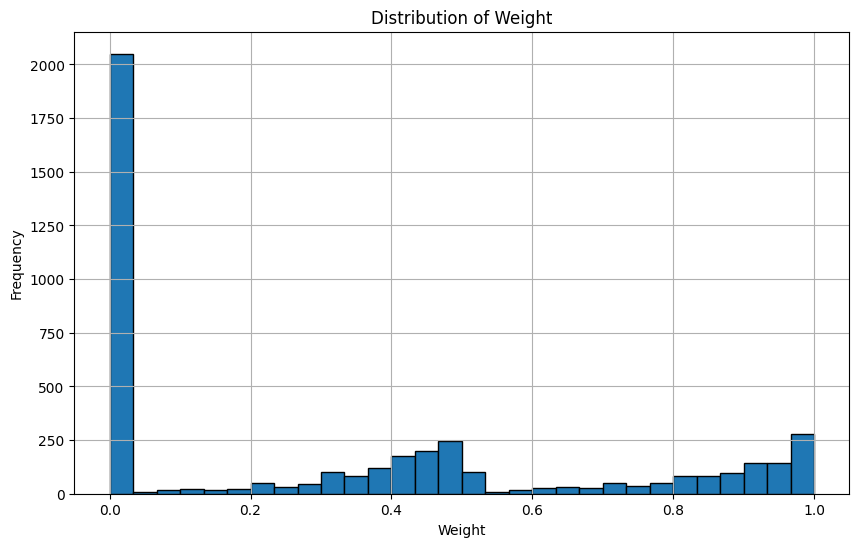

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming match_data is already defined and loaded
plt.figure(figsize=(10, 6))
plt.hist(match_data['Weight'], bins=30, edgecolor='black')
plt.title('Distribution of Weight')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [2]:
import os
import sys
import time
import argparse
from pathlib import Path

import numpy as np
import pandas as pd
import muon as mu
import pyranges as pr

import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve
)

from typing import Literal



# Adjust the path to point to the parent of 'utils' (i.e., workflow/)
utils_path = Path.cwd().parent / "utils"
sys.path.append(str(utils_path))

from benchmarking_metrics import *

GRN_TOOLS = Literal["scenicplus", "celloracle"]
SCORE_COL = "score_rank"
TF2GENE_W_COL = "TF2Gene_weight"

def modality_names(grn_tool:GRN_TOOLS, cell_type_col, sample):
    if grn_tool == "scenicplus":
        if "metacell_0" in sample:
            return "scRNA_counts", "scATAC_counts", f"scRNA_counts:{cell_type_col}"
        else:
            return "scRNA_counts", "scATAC_counts", "scRNA_counts:Metacell_Key"

def get_adata(mudata, grn_tool:GRN_TOOLS):
    if grn_tool == "scenicplus":
        return mudata["scRNA_counts"]
    else:
        raise ValueError(f"Unsupported GRN inference tool: {grn_tool}")


def get_mudata(path:str, grn_tool:GRN_TOOLS):
    if grn_tool == "scenicplus":
        scplus_mdata = mu.read_h5mu(path)
        return scplus_mdata
    else:
        raise ValueError(f"Unsupported GRN inference tool: {grn_tool}")

# GRNs need to have the following columns: "TF", "Gene", "Region"
def preprocess_scenicplus(scplus_mdata):
    # Extract metadata
    direct_df = pd.DataFrame(scplus_mdata.uns['direct_e_regulon_metadata'])
    extended_df = pd.DataFrame(scplus_mdata.uns['extended_e_regulon_metadata'])

    # Combine into one DataFrame
    grn = pd.concat([direct_df, extended_df], ignore_index=True)

    # Filter the relevant columns
    grn_filtered = grn[['Region', 'Gene', 'TF', 'importance_TF2G', 'importance_R2G','regulation', 'rho_TF2G', 'triplet_rank']].copy()

    # Split the 'Region' column into Chromosome, Start, End
    region_split = grn_filtered['Region'].str.extract(r'(chr[\w]+):(\d+)-(\d+)')
    region_split.columns = ['Chromosome', 'Start', 'End']

    # Convert Start and End to integers
    region_split['Start'] = region_split['Start'].astype(int)
    region_split['End'] = region_split['End'].astype(int)

    grn = pd.concat([region_split, grn_filtered], axis=1)

    max_rank = grn["triplet_rank"].max()
    min_rank = grn["triplet_rank"].min()

    grn[SCORE_COL] = (max_rank - grn["triplet_rank"]) / (max_rank - min_rank)

    raw = grn["importance_TF2G"] * grn["rho_TF2G"]
    grn[TF2GENE_W_COL] = np.tanh(3 * raw) 

    return grn

def get_grn_matrix(mudata, grn_tool:GRN_TOOLS):
    if grn_tool == "scenicplus":
        return preprocess_scenicplus(mudata)

def get_benchmark_matrix(tfb_path, prt_path, frc_path, gst_path, tfm_path):
    tfb_matrix = pd.read_csv(tfb_path, sep="\t", header=None)
    tfb_matrix.columns = ["Chromosome", "Start", "End", "TF"]

    prt_matrix = pd.read_csv(prt_path, sep=',')

    frc_matrix = pd.read_csv(frc_path, index_col=0, sep=',')

    gst_matrix = pd.read_csv(gst_path)

    tfm_matrix = df = pd.read_csv(tfm_path, header=None, names=['gene'])

    return tfb_matrix, prt_matrix, frc_matrix, gst_matrix, tfm_matrix

In [3]:

mudata = get_mudata("/data/tmpA/andrem/scenicplus/results/AML16_REM_MO_scdart_metacell_0/scplusmdata.h5mu", "scenicplus")
grn_inferred = get_grn_matrix(mudata, "scenicplus")

In [ ]:
AML16_REM_MO_scdart_metacell_0

In [4]:
rna_mod_name, atac_mod_name, celltype_col = modality_names("scenicplus", "Classified_Celltype", "AML16_REM_MO_scdart_metacell_0 ")

In [11]:
mudata

MuData object with n_obs × n_vars = 3651 × 199443
  uns:	'direct_e_regulon_metadata', 'extended_e_regulon_metadata'
  6 modalities
    scRNA_counts:	3651 x 33538
      obs:	'patient', 'dx', 'sample', 'batch', 'GEO_ID', 'Lambo_et_al_ID', 'Patient_Sample', 'Library_ID', 'Counts', 'Features', 'Mitochondria_percent', 'Classified_Celltype', 'Seurat_Cluster', 'Malignant', 'Patient_ID', 'Biopsy_Origin', 'Age_Months', 'Disease_free_days', 'Clinical_Blast_Percent', 'Expected_Driving_Aberration', 'Subgroup', 'Color_Subgroup', 'Known_CNVs', 'Treatment_Outcome', 'nCount_RNA', 'nFeature_RNA', 'doublet', 'doublet_score', 'Metacell_Key'
      var:	'gene_ids', 'feature_types', 'genome'
      obsm:	'X_pca', 'X_umap', 'integration_embedding'
    scATAC_counts:	3651 x 165675
      obs:	'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'sample_id', 'Unique_nr_frag', 'barcode', 'Cell_Barcode', 'GEO_ID', 'Lambo_et_al_ID', 'Patient_Sample', 'Library_ID', 'Total_fragments', 'ReadsInTSS', 'ReadsInPeaks', 'FractionInPeaks', 'Classified_Celltype', 'ArchR_clusters', 'Malignant', 'Linked_scRNA_barcode', 'Linked_scRNA_Sample', 'Linked_scRNA_confidence_score', 'Patient_ID', 'Biopsy_Origin', 'Age_Months', 'Disease_free_days', 'Clinical_Blast_Percent', 'Expected_Driving_Aberration', 'Subgroup', 'Color_Subgroup', 'Known_CNV', 'Treatment_Outcome', 'integration_embedding', 'Old_Classified_Celltype', 'Metacell_Key'
      var:	'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc'
    direct_gene_based_AUC:	3651 x 61
    direct_region_based_AUC:	3651 x 61
    extended_gene_based_AUC:	3651 x 54
    extended_region_based_AUC:	3651 x 54

In [9]:
mudata.obs['scRNA_counts:Classified_Celltype']

AGCTGATAGCTCCGGT-1___AML16_REM         Monocytes
GTGGCGTCAACTTGGT-1___AML16_REM         CD4.Naive
ACTGTCCTCCCAGCGA-1___AML16_REM    CD16.Monocytes
GAAACAAGTATTCGAC-1___AML16_REM         Monocytes
CCCGTTATCTGGAAGG-1___AML16_REM         Monocytes
                                       ...      
CCGTACTGTTCTACGA-1___AML16_REM         CD4.Naive
GCCTAGGGTATGGATA-1___AML16_REM         CD8.Naive
CTTTGCGTCTCCTTAA-1___AML16_REM               GMP
CTAACTTCATCATCGA-1___AML16_REM        CD4.Memory
CGGACTGCAGGTAGCA-1___AML16_REM         CD8.Naive
Name: scRNA_counts:Classified_Celltype, Length: 3651, dtype: category
Categories (18, object): ['B.Cell', 'CD4.Memory', 'CD4.Naive', 'CD8.Effector', ..., 'NK', 'Pre.B.Cell', 'cDC', 'pDC']

In [10]:
mudata.obs['scRNA_counts:Classified_Celltype'].value_counts().sort_index()


B.Cell                  5
CD4.Memory            359
CD4.Naive            1012
CD8.Effector          104
CD8.Memory             55
CD8.Naive             137
CD16.Monocytes        109
CLP                     2
Early.Basophil          6
Early.Erythrocyte      31
GMP                    11
HSC                     6
Late.Erythrocyte        1
Monocytes            1573
NK                     73
Pre.B.Cell              1
cDC                    84
pDC                    82
Name: scRNA_counts:Classified_Celltype, dtype: int64

In [7]:
import celloracle as co
base_GRN = co.data.load_human_promoter_base_GRN(version="hg38_gimmemotifsv5_fpr2")

Loading prebuilt promoter base-GRN. Version: hg38_gimmemotifsv5_fpr2


In [2]:
base_GRN

,peak_id,gene_short_name,9430076C15RIK,AC002126.6,AC012531.1,AC226150.2,AFP,AHR,AHRR,AIRE,...,ZNF784,ZNF8,ZNF816,ZNF85,ZSCAN10,ZSCAN16,ZSCAN22,ZSCAN26,ZSCAN31,ZSCAN4
0,chr10_100009853_100010953,DNMBP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,chr10_100081785_100082885,CPN1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,chr10_100185877_100186977,ERLIN1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,chr10_100186978_100187057,ERLIN1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,chr10_100229510_100230610,CHUK,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39310,chrY_9721196_9722296,TTTY21B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39311,chrY_9735286_9736386,TTTY2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
39312,chrY_9774219_9775319,TTTY1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39313,chrY_9800153_9801253,TTTY22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
peak_coords = base_GRN["peak_id"].str.split("_", expand=True)

In [8]:
peak_coords[1].str.isnumeric()

0        True
1        True
2        True
3        True
4        True
         ... 
39310    True
39311    True
39312    True
39313    True
39314    True
Name: 1, Length: 39315, dtype: bool

In [1]:
import celloracle as co
links = co.data.load_tutorial_links_object()

Data not found in the local folder. Loading data from github. Data will be saved at /home/andrem/celloracle_data/tutorial_data


  0%|          | 0.00/59.6M [00:00<?, ?B/s]

In [10]:
links.links_dict

{'Ery_0':         source         target  coef_mean  coef_abs             p     -logp
 0         Irf7  0610007L01Rik  -0.009400  0.009400  4.912392e-08  7.308707
 1         Fli1  0610007L01Rik   0.000347  0.000347  8.124897e-01  0.090182
 2        Foxp1  0610007L01Rik  -0.007035  0.007035  3.098882e-04  3.508795
 3         Chd2  0610007L01Rik  -0.010569  0.010569  5.736120e-06  5.241382
 4        Stat1  0610007L01Rik   0.000632  0.000632  3.694124e-01  0.432489
 ...        ...            ...        ...       ...           ...       ...
 74932    Stat3            Zyx   0.020598  0.020598  6.122543e-09  8.213068
 74933     Nfic            Zyx  -0.002065  0.002065  3.726469e-01  0.428702
 74934   Stat5a            Zyx  -0.016722  0.016722  1.102916e-07  6.957457
 74935    Hnf4a            Zyx   0.000219  0.000219  9.233685e-01  0.034625
 74936  Smarcc1            Zyx   0.004714  0.004714  2.525124e-02  1.597717
 
 [74937 rows x 6 columns],
 'Ery_1':         source         target  coef_mean

In [8]:
def expand_links_with_CREs(links, base_GRN):
    records = []

    for _, row in links.iterrows():
        tf = row["source"]
        gene = row["target"]

        coef_mean = row["coef_mean"]
        coef_abs = row["coef_abs"]
        p = row["p"]
        logp = row["-logp"] 

        # Default record in case no CREs are found
        default_record = {
            "source": tf,
            "target": gene,
            "coef_mean": coef_mean,
            "coef_abs": coef_abs,
            "p": p,
            "-logp": logp,
            "chromosome": np.nan,
            "start": np.nan,
            "end": np.nan
        }

        if tf in base_GRN.columns:
            peaks = base_GRN[
                (base_GRN["gene_short_name"] == gene) &
                (base_GRN[tf] != 0)
            ][["chromosome", "start", "end"]]

            if not peaks.empty:
                for _, peak in peaks.iterrows():
                    records.append({
                        "source": tf,
                        "target": gene,
                        "coef_mean": coef_mean,
                        "coef_abs": coef_abs,
                        "p": p,
                        "-logp": logp,
                        "chromosome": peak["chromosome"],
                        "start": peak["start"],
                        "end": peak["end"]
                    })
                continue  # skip adding default row

        # Append one row with NaNs if no matching peaks or TF not in base_GRN
        records.append(default_record)

    expanded_df = pd.DataFrame(records)
    return expanded_df

In [ ]:
import pandas as pd
import time
def expand_links_with_CREs(links, base_GRN):
    # Prepare base_GRN in long format: one row per (TF, gene)
    tf_columns = [col for col in base_GRN.columns if col not in ["gene_short_name", "chromosome", "start", "end"]]

    melted = base_GRN.melt(
        id_vars=["gene_short_name", "chromosome", "start", "end"],
        value_vars=tf_columns,
        var_name="source",
        value_name="score"
    )
    
    # Filter non-zero scores (active TF-gene interactions)
    melted = melted[melted["score"] != 0]

    # Merge links with base_GRN annotations
    annotated = pd.merge(
        links,
        melted,
        how="left",
        left_on=["source", "target"],
        right_on=["source", "gene_short_name"]
    )

    # Drop extra column
    annotated = annotated.drop(columns=["score", "gene_short_name"])

    # For rows with no CRE info, fill NaNs as before
    for col in ["chromosome", "start", "end"]:
        if col not in annotated.columns:
            annotated[col] = np.nan

    return annotated

def flatten_links_object(links_obj):
    """Convert CellOracle Links object to a flat DataFrame with cluster labels."""
    records = []
    for cluster_name, df in links_obj.links_dict.items():
        df = df.copy()
        df["cluster"] = cluster_name
        records.append(df)
    return pd.concat(records, ignore_index=True)


NameError: name 'tf_columns' is not defined

In [ ]:
links_flat = flatten_links_object(links)


In [ ]:

if "peak_id" in base_GRN.columns:
    peak_coords = base_GRN["peak_id"].str.split("_", expand=True)

    # Then validate that 'start' and 'end' columns are numeric
    is_numeric_start = peak_coords[1].str.isnumeric()
    is_numeric_end = peak_coords[2].str.isnumeric()
    valid_rows = is_numeric_start & is_numeric_end

    if not valid_rows.any():
        raise ValueError("No valid 'peak_id' entries with numeric coordinates found.")

    peak_coords = peak_coords[valid_rows]
    base_GRN = base_GRN.loc[valid_rows].copy()
    base_GRN["chromosome"] = peak_coords[0].values
    base_GRN["start"] = peak_coords[1].astype(int).values
    base_GRN["end"] = peak_coords[2].astype(int).values
else:
    raise ValueError("Expected 'peak_id' column in base_GRN, but it was not found.")


In [19]:
expanded_links = expand_links_with_CREs(links_flat, base_GRN)


In [26]:
base_GRN

,peak_id,gene_short_name,9430076C15RIK,AC002126.6,AC012531.1,AC226150.2,AFP,AHR,AHRR,AIRE,...,ZNF85,ZSCAN10,ZSCAN16,ZSCAN22,ZSCAN26,ZSCAN31,ZSCAN4,chromosome,start,end
0,chr10_100009853_100010953,DNMBP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,chr10,100009853,100010953
1,chr10_100081785_100082885,CPN1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,chr10,100081785,100082885
2,chr10_100185877_100186977,ERLIN1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,chr10,100185877,100186977
3,chr10_100186978_100187057,ERLIN1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,chr10,100186978,100187057
4,chr10_100229510_100230610,CHUK,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,chr10,100229510,100230610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39310,chrY_9721196_9722296,TTTY21B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,chrY,9721196,9722296
39311,chrY_9735286_9736386,TTTY2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,chrY,9735286,9736386
39312,chrY_9774219_9775319,TTTY1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,chrY,9774219,9775319
39313,chrY_9800153_9801253,TTTY22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,chrY,9800153,9801253


In [23]:
common_targets = expanded_links[expanded_links["target"].isin(base_GRN["gene_short_name"])]


In [27]:
expanded_links.chromosome.unique()

array([nan], dtype=object)